In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from matplotlib.colors import ListedColormap
import numpy as np
from scipy.stats import gaussian_kde
from loguru import logger

plt.rcParams["font.family"] = "Arial"  # 设置字体族为你指定的字体

In [2]:
def get_core_set(full_set: pd.DataFrame, clusters_test_path: Path = Path("./clusters_test.pkl")):
    full_set = full_set.copy()
    with clusters_test_path.open("br") as f:
        clusters_test = pickle.load(f)

    def get_redundency(job_name):
        pdb_id = job_name.split("_")[0]
        if pdb_id in clusters_test["test_independent_set"]:
            return 0
        elif pdb_id in clusters_test["test_redundent_set"]:
            return 1
        elif pdb_id in clusters_test["train_redundent_set"]:
            return 2
        else:
            raise ValueError(f"{pdb_id} not in cluster test set")

    full_set["redundency"] = full_set["job_id"].apply(get_redundency)
    print(f"len(full_set): {len(full_set)}")
    print(
        f"Test Independant Set (N): {len(clusters_test['test_independent_set'])}\n"
        f"Test Redundent Set (N): {len(clusters_test['test_redundent_set'])}\n"
        f"Train Redundent Set (N): {len(clusters_test['train_redundent_set'])}\n"
    )

    return full_set[full_set["redundency"] == 0]

In [3]:
results_dir = Path("../results")

df_summary = pd.read_csv(results_dir / "job_summary.csv")
df_summary.rename(columns={"job_name": "job_id"}, inplace=True)

df_energy = pd.read_csv(results_dir / "deltaG_native.csv")
df_iASA = pd.read_csv(results_dir / "iASA_native.csv")

In [4]:
df = pd.merge(df_summary, df_energy, on="job_id", how="left")
df = pd.merge(df, df_iASA, on="job_id", how="left")

In [5]:
missing_data_df = df[df.isnull().any(axis=1)]
logger.info("Below are examples of rows with missing values after merging:")
logger.info(missing_data_df)

2025-04-04 19:00:59.186 | INFO     | __main__:<module>:2 - Below are examples of rows with missing values after merging:
2025-04-04 19:00:59.189 | INFO     | __main__:<module>:3 - Empty DataFrame
Columns: [job_id, pdb_id, peptide_chains, protein_chains, peptide_chain_len, peptide_chain_has_ncaa, msa_status_af3, infer_status_af3, model_name_x, dG_separated, dG_cross, sc_value, nres_all, nres_int, total_score, binding_energy, model_name_y, iASA, iASA%, sasa_peptide, sasa_protein, sasa_complex]
Index: []

[0 rows x 22 columns]


In [6]:
print(len(df))

261


In [7]:
full_set = df.copy()
core_set = get_core_set(full_set)

len(full_set): 261
Test Independant Set (N): 172
Test Redundent Set (N): 32
Train Redundent Set (N): 79



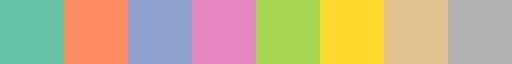

In [8]:
cmap = plt.get_cmap("Set2")
cmap

In [9]:
colors_deep = ["#44A0FB", "#FF7802"]  # 蓝\橙
colors_shallow = ["#96D0FF", "#F9C2AD"]  # 深蓝\深橙
cmap_shallow = ListedColormap(colors_shallow)
cmap_deep = ListedColormap(colors_deep)

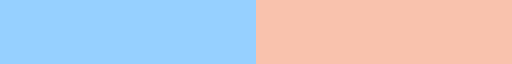

In [10]:
cmap_shallow

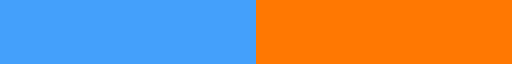

In [11]:
cmap_deep

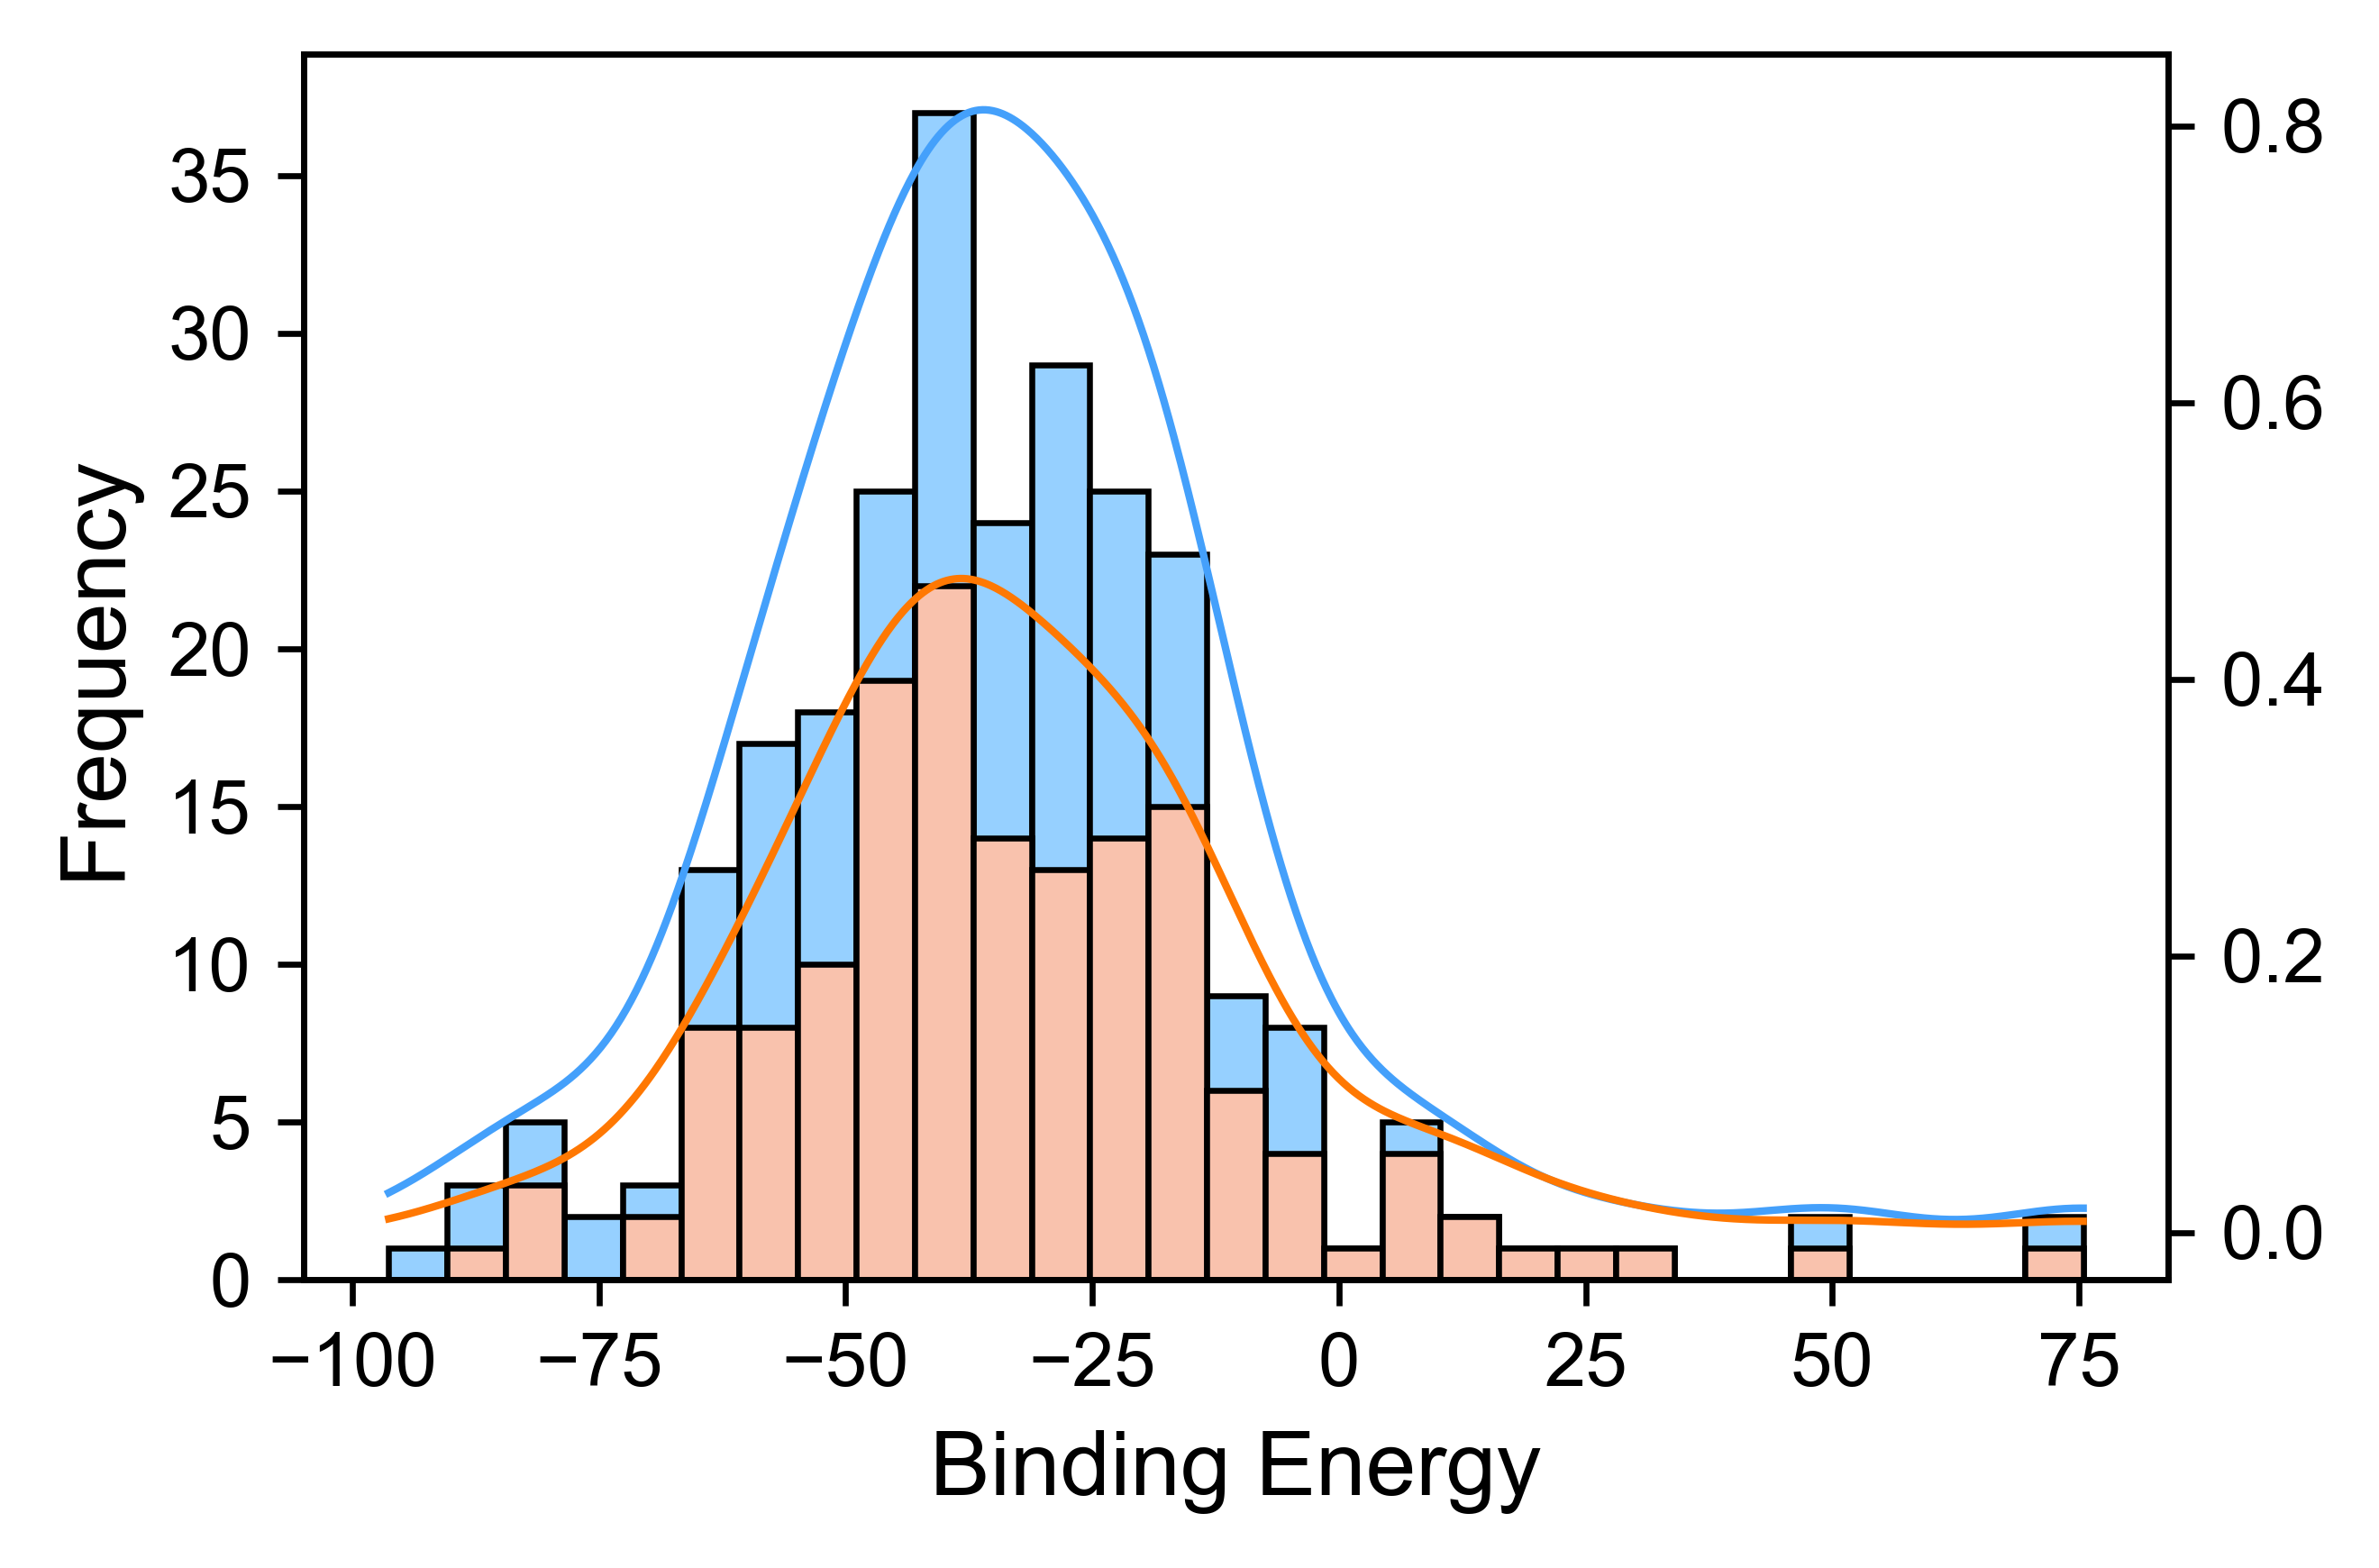

In [14]:
def plot_energy(fullset_df: pd.DataFrame, coreset_df: pd.DataFrame):
    fullset_filtered = fullset_df[fullset_df["dG_cross"] <= 100]
    coreset_filtered = coreset_df[coreset_df["dG_cross"] <= 100]

    min_value = min(fullset_filtered["dG_cross"].min(), coreset_filtered["dG_cross"].min())
    max_value = max(fullset_filtered["dG_cross"].max(), coreset_filtered["dG_cross"].max())
    
    bins = np.linspace(min_value, max_value, 30)

    fig, ax = plt.subplots(figsize=(4.5, 3), dpi=600)
    # 绘制柱状图，不进行归一化
    sns.histplot(
        data=fullset_filtered,
        x="dG_cross",
        bins=bins,
        kde=False,  # 这里关闭KDE
        color=cmap_shallow(0),
        ax=ax,
        label="Full Set",
        alpha=1,
        stat="count"  # 保证柱状图显示原始频数
    )
    sns.histplot(
        data=coreset_filtered,
        x="dG_cross",
        bins=bins,
        kde=False,  # 关闭KDE
        color=cmap_shallow(1),
        ax=ax,
        label="Core Set",
        alpha=1,
        stat="count"  # 保证柱状图显示原始频数
    )
    
    # 创建第二个坐标轴用于绘制KDE
    ax2 = ax.twinx()

    # 手动计算KDE并缩放
    kde_fullset = gaussian_kde(fullset_filtered["dG_cross"], bw_method='scott')
    kde_coreset = gaussian_kde(coreset_filtered["dG_cross"], bw_method='scott')

    # 获取x轴范围
    x_range = np.linspace(min(fullset_filtered["dG_cross"].min(), coreset_filtered["dG_cross"].min()),
                          max(fullset_filtered["dG_cross"].max(), coreset_filtered["dG_cross"].max()), 1000)

    # 计算KDE值并缩放
    kde_fullset_values = kde_fullset(x_range) * len(fullset_filtered) * (x_range[1] - x_range[0])
    kde_coreset_values = kde_coreset(x_range) * len(coreset_filtered) * (x_range[1] - x_range[0])

    # 绘制KDE曲线，缩放后与柱状图的频数一致
    ax2.plot(x_range, kde_fullset_values, color=cmap_deep(0), label="PepPCDB KDE", lw=1, alpha=1)
    ax2.plot(x_range, kde_coreset_values, color=cmap_deep(1), label="PepPCDB-Core KDE", lw=1, alpha=1)

    # 设置图例
    # ax.set_title("Binding Energy Distribution", fontsize=14, pad=15)
    ax.set_xlabel(r"Binding Energy", fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    # ax2.set_ylabel("Density (scaled)", fontsize=12)
    # ax.legend()

    plt.tight_layout()
    plt.show()

plot_energy(full_set, core_set)

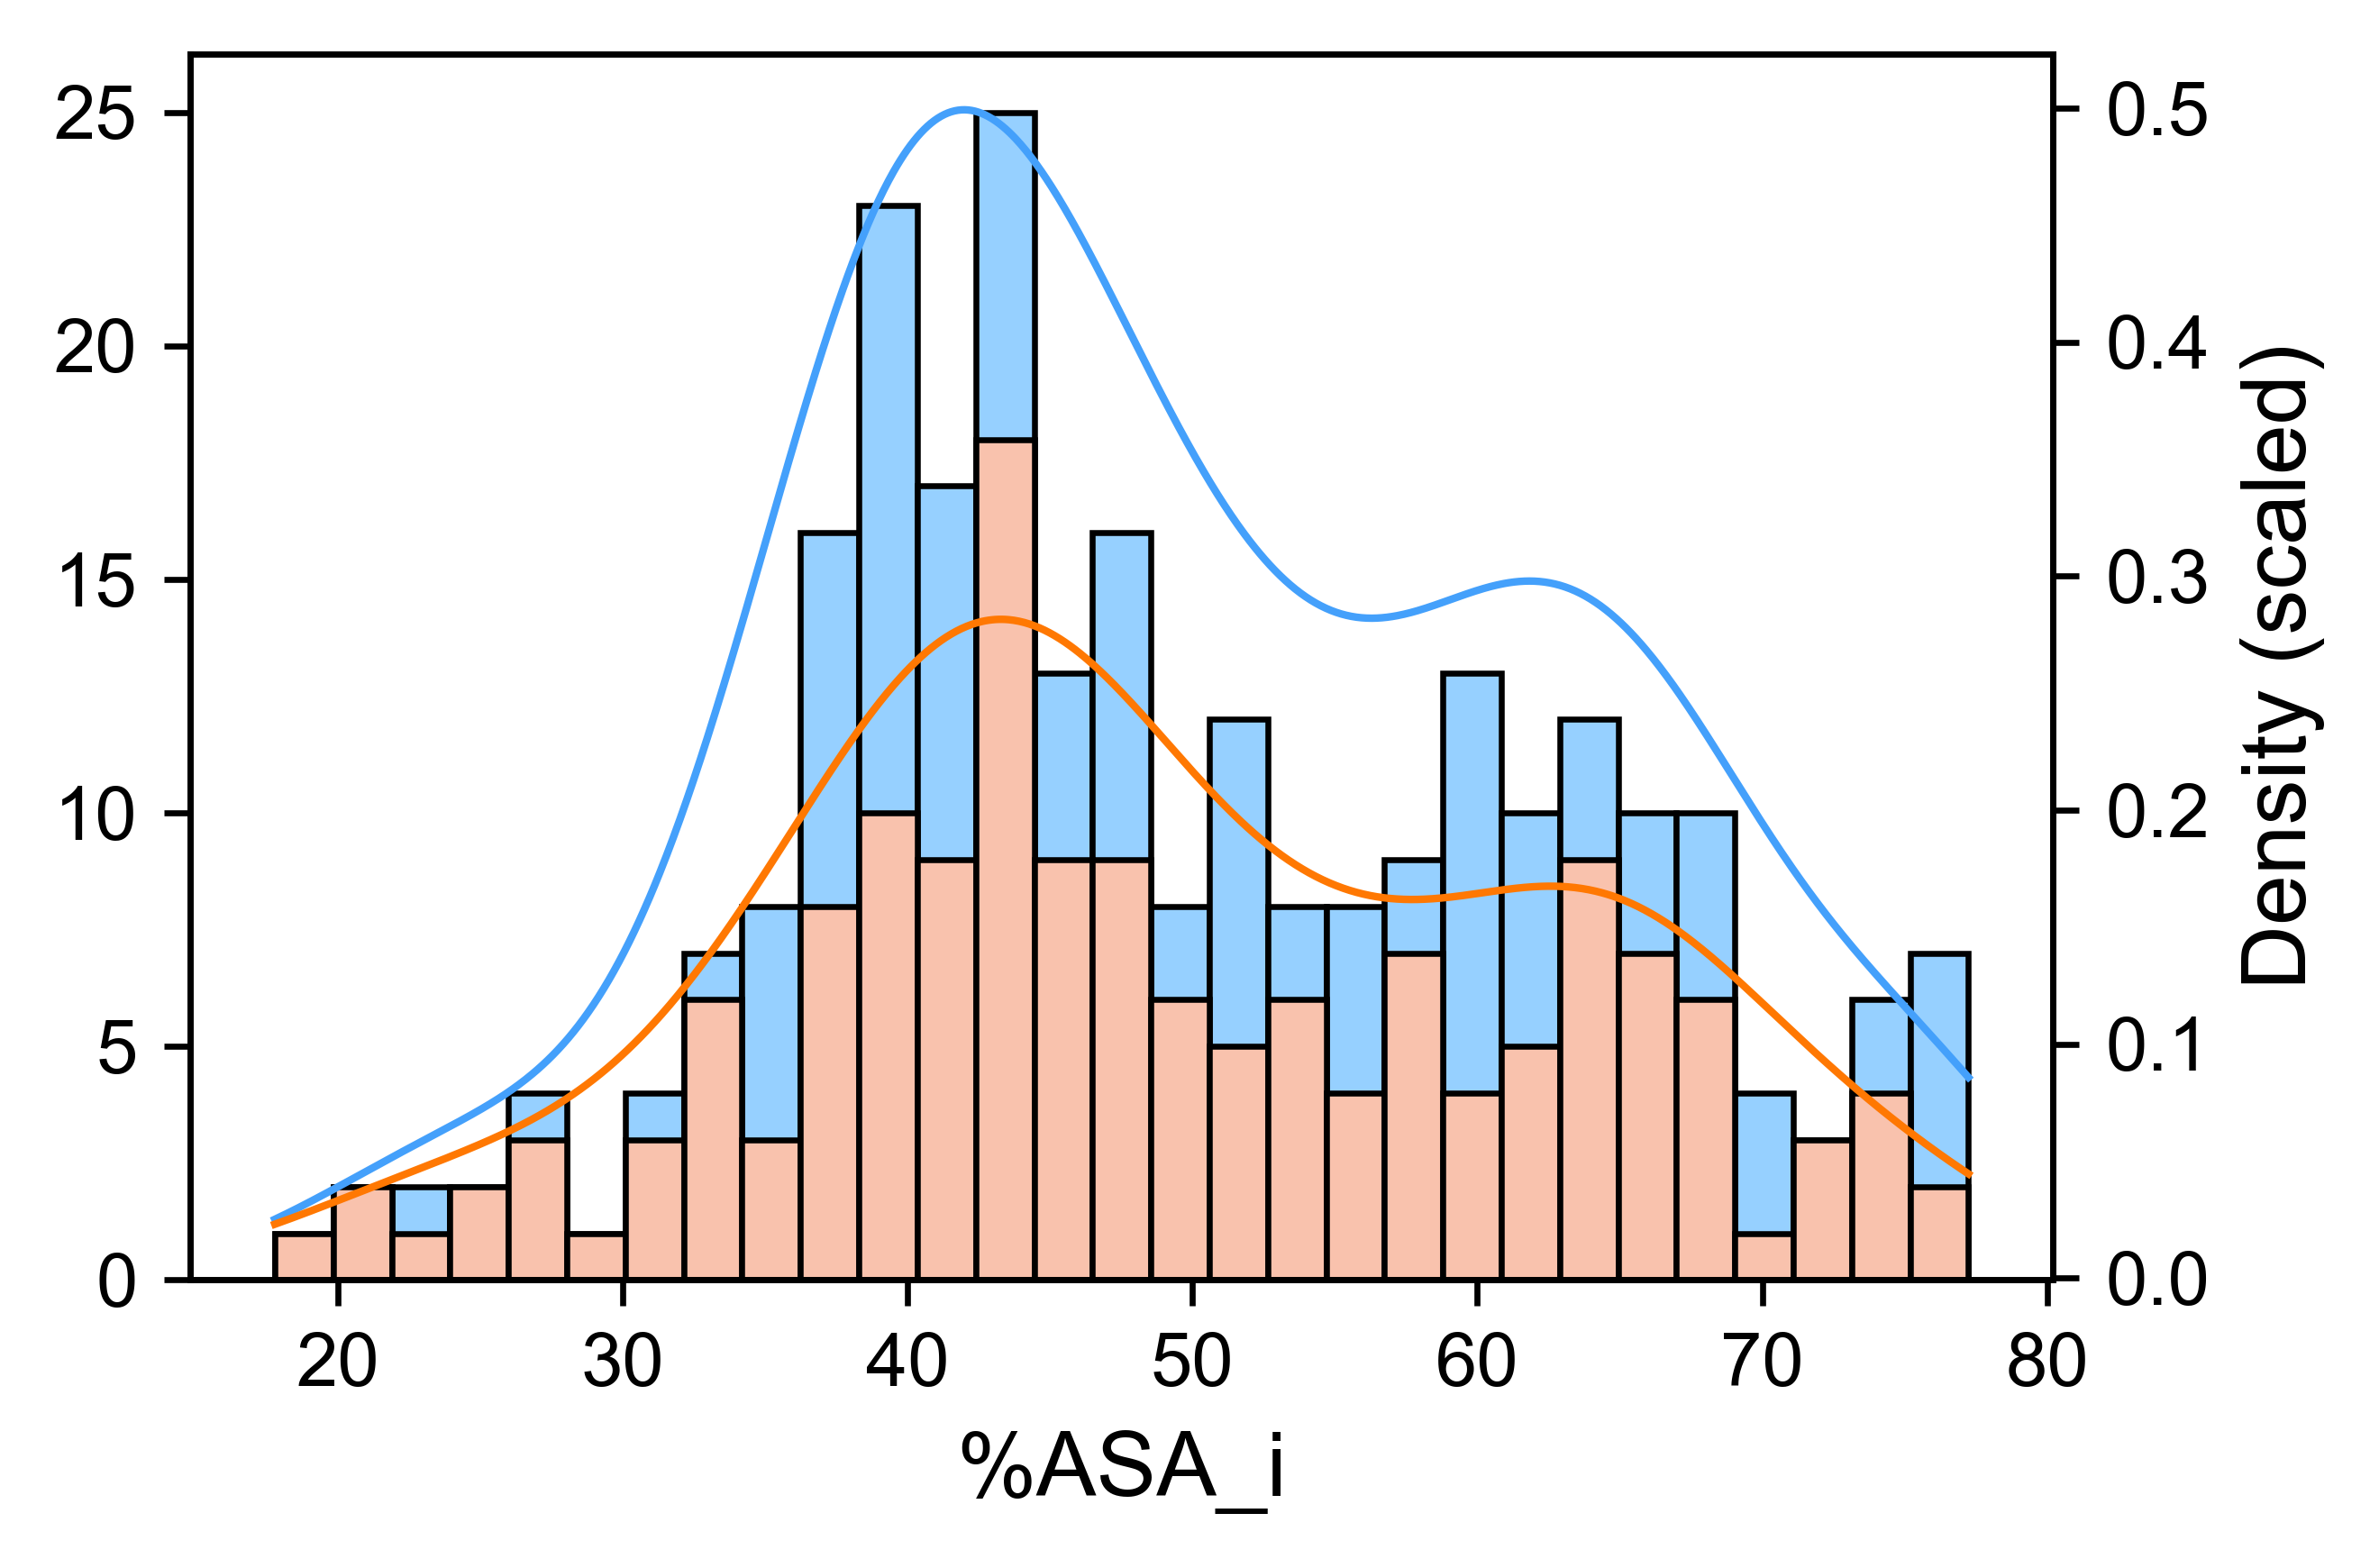

In [13]:
def plot_iASA(fullset_df: pd.DataFrame, coreset_df: pd.DataFrame):
    fig, ax = plt.subplots(figsize=(4.5, 3), dpi=600)
    
    min_value = min(fullset_df["iASA%"].min(), coreset_df["iASA%"].min())
    max_value = max(fullset_df["iASA%"].max(), coreset_df["iASA%"].max())
    bins = np.linspace(min_value, max_value, 30)
    
    sns.histplot(
        data=fullset_df,
        x="iASA%",
        bins=bins,
        kde=False,
        color=cmap_shallow(0),
        ax=ax,
        label="Full Set",
        alpha=1,
    )
    
    sns.histplot(
        data=coreset_df,
        x="iASA%",
        bins=bins,
        kde=False,
        color=cmap_shallow(1),
        ax=ax,
        label="Core Set",
        alpha=1,
    )

    # 创建第二个坐标轴用于绘制KDE
    ax2 = ax.twinx()

    # 手动计算KDE并缩放
    kde_fullset = gaussian_kde(fullset_df["iASA%"], bw_method='scott')
    kde_coreset = gaussian_kde(coreset_df["iASA%"], bw_method='scott')

    # 获取x轴范围
    x_range = np.linspace(min(fullset_df["iASA%"].min(), coreset_df["iASA%"].min()),
                          max(fullset_df["iASA%"].max(), coreset_df["iASA%"].max()), 1000)

    # 计算KDE值并缩放
    kde_fullset_values = kde_fullset(x_range) * len(fullset_df) * (x_range[1] - x_range[0])
    kde_coreset_values = kde_coreset(x_range) * len(coreset_df) * (x_range[1] - x_range[0])

    # 绘制KDE曲线，缩放后与柱状图的频数一致
    ax2.plot(x_range, kde_fullset_values, color=cmap_deep(0), label="PepPCDB KDE", lw=1, alpha=1)
    ax2.plot(x_range, kde_coreset_values, color=cmap_deep(1), label="PepPCDB-Core KDE", lw=1, alpha=1)

    # ax.set_title("diASA% Distribution", fontsize=14, pad=15)
    ax.set_xlabel("%ASA_i", fontsize=12)
    ax.set_ylabel("", fontsize=12)
    ax2.set_ylabel("Density (scaled)", fontsize=12)
    # ax.legend()
    
    plt.tight_layout()
    plt.show()


plot_iASA(full_set, core_set)

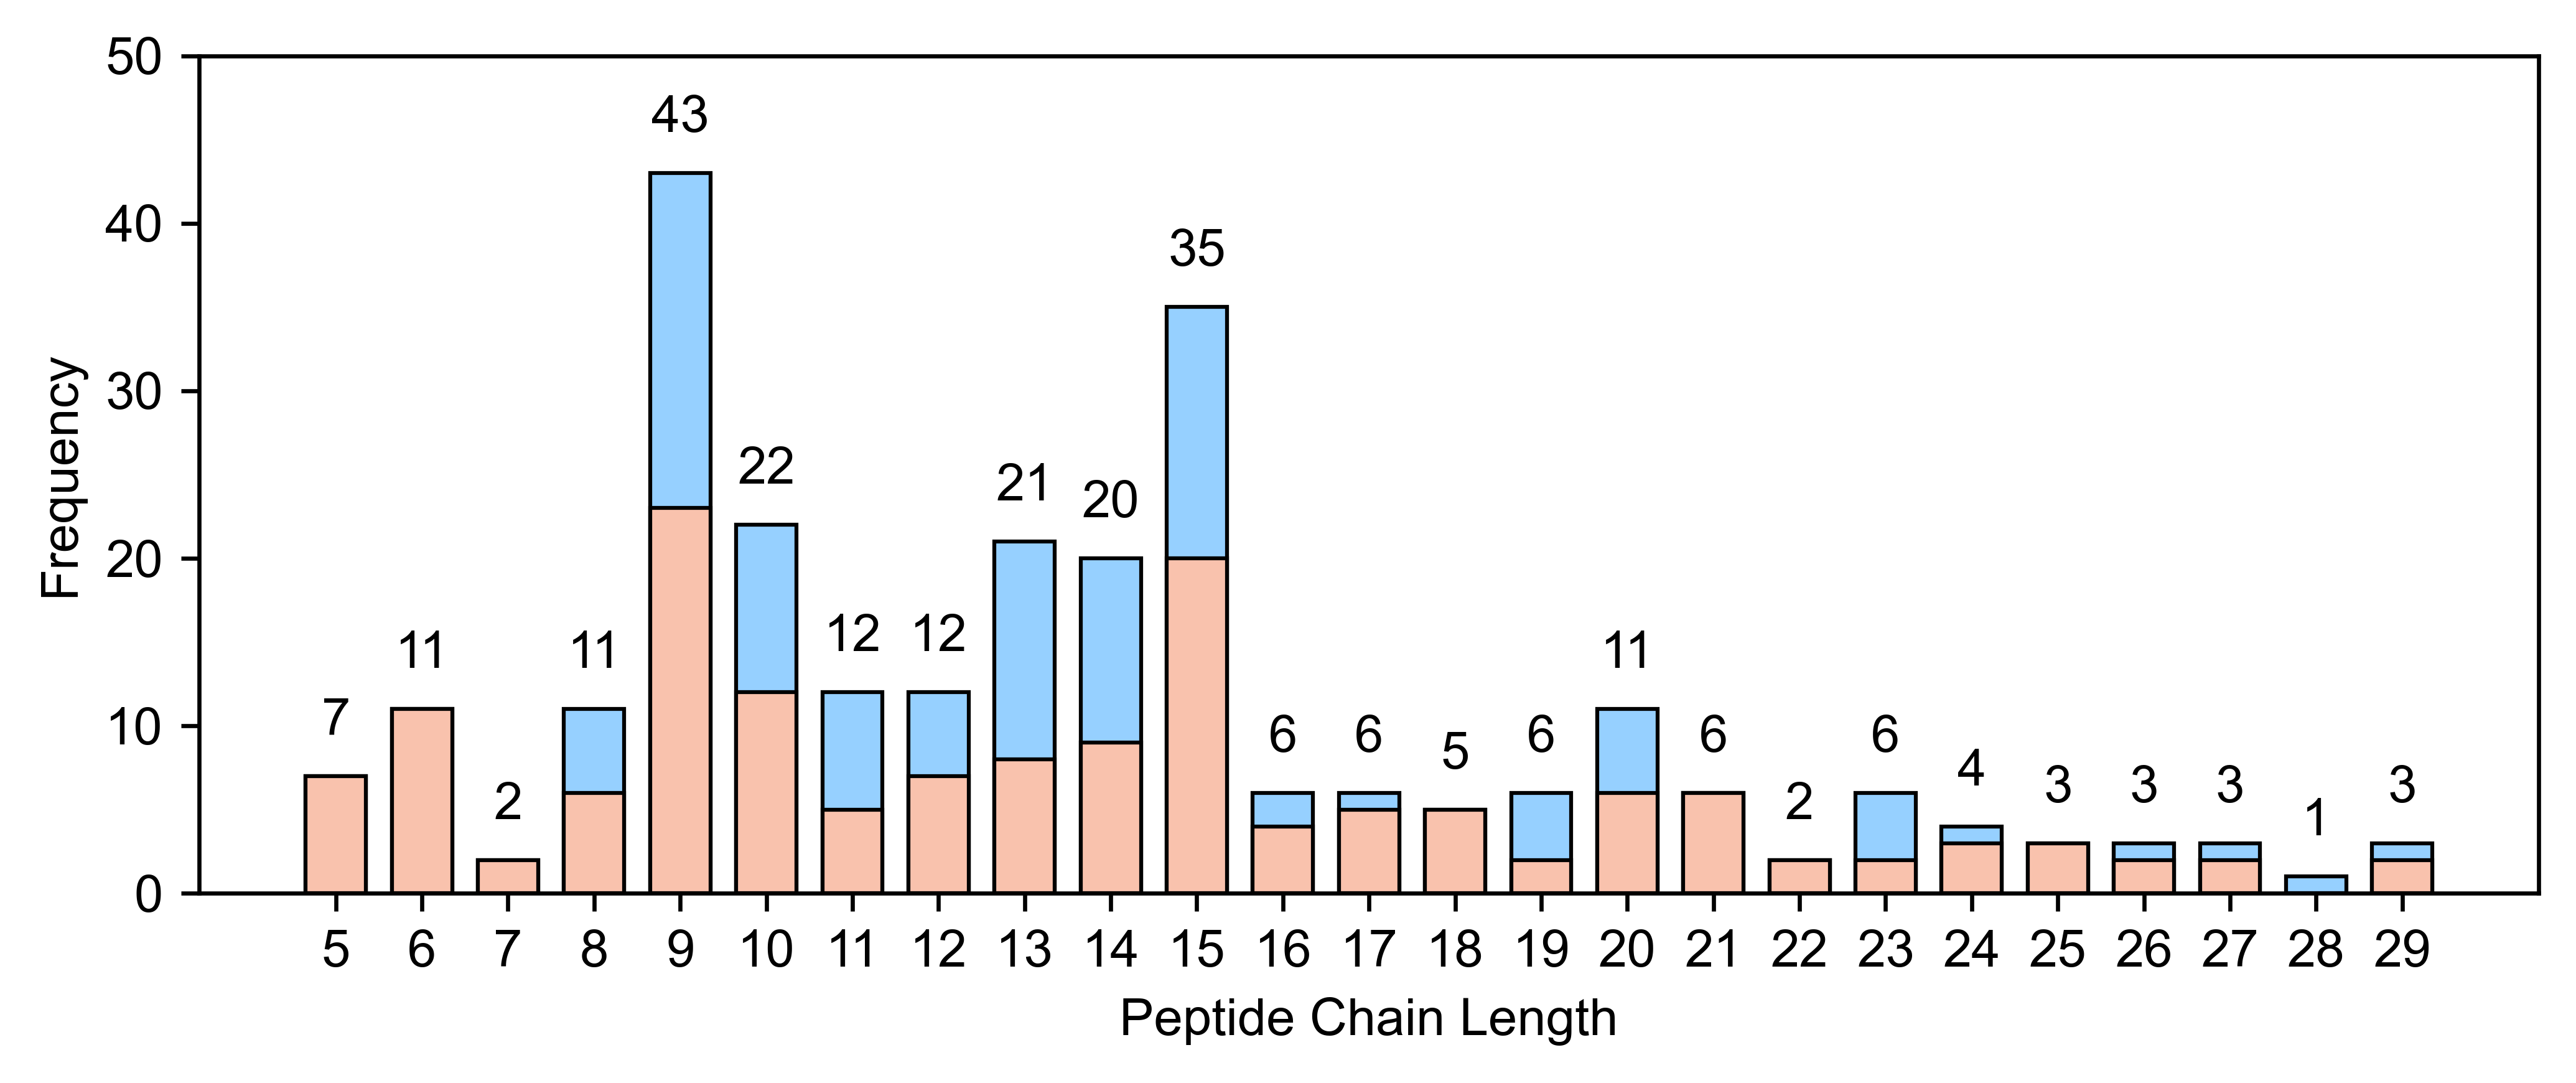

In [18]:
def plot_length(fullset_df: pd.DataFrame, coreset_df: pd.DataFrame):
    
    fig, ax = plt.subplots(figsize=(7, 3), dpi=600)

    # 计算每个长度的频率
    fullset_counts = fullset_df["peptide_chain_len"].value_counts().sort_index()
    coreset_counts = coreset_df["peptide_chain_len"].value_counts().sort_index()

    # 获取 x 轴的位置
    fullset_x = fullset_counts.index
    coreset_x = coreset_counts.index
    
    width = 0.7
    
    # 绘制 PepPCDB 的柱状图（第一个数据集）
    ax.bar(
        fullset_x,  # x 位置
        fullset_counts.values,
        color=cmap_shallow(0),
        edgecolor="black",
        label="Full Set",
        linewidth=0.75,
        width=width,
        alpha=1
    )

    # 绘制 PepPCDB-Core 的柱状图（第二个数据集）
    ax.bar(
        coreset_x,  # x 位置
        coreset_counts.values,
        color=cmap_shallow(1),
        edgecolor="black",
        label="Core Set",
        linewidth=0.75,
        width=width,
        alpha=1
    )

    # 在每个柱子的顶部添加数值标签（只对较高的柱子添加）
    for i in range(len(fullset_counts)):
        full_height = fullset_counts.values[i]
        core_height = coreset_counts.get(fullset_counts.index[i], 0)  # 获取对应的值，没有值则为 0
        
        # 选择更高的柱子来显示数值标签
        max_height = max(full_height, core_height)
        x_position = fullset_counts.index[i] if full_height >= core_height else coreset_counts.index[i]
        
        ax.annotate(
            f"{max_height:,.0f}",
            (x_position, max_height),  # 在更高的柱子顶部显示标签
            ha="center",
            va="bottom",  # 文本底部对齐柱子的顶部
            color="black",
            xytext=(0, 6),  # 相对于柱子的偏移量
            textcoords="offset points",
        )

    # 设置标题和轴标签
    # ax.set_title("Peptide Chain Length Distribution")
    ax.set_xlabel("Peptide Chain Length")
    ax.set_ylabel("Frequency")

    # 设置 y 轴范围
    ax.set_ylim(0, 50)
    ax.set_xticks(np.arange(min(fullset_x.min(), coreset_x.min()), max(fullset_x.max(), coreset_x.max()) + 1, 1))

    # 添加图例
    # ax.legend()

    # 调整布局
    plt.tight_layout()
    plt.show()

# 调用绘图函数
plot_length(full_set, core_set)